In [1]:
# importing basic EDA libraires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# machine learning libraies to train and evaluate model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# setting figure parameters
sns.set_theme(palette='viridis',style='darkgrid')
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 150

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import influence_plot

In [2]:
df = pd.read_csv('50_Startups.csv')

In [3]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [5]:
df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [6]:
# renaming columns
df.rename({'R&D Spend':'RD_Spend','Marketing Spend': 'Marketing_Spend'},axis = 1,inplace = True)

In [7]:
# dropping states column as it is not required
df.drop('State',axis = 1, inplace=True)

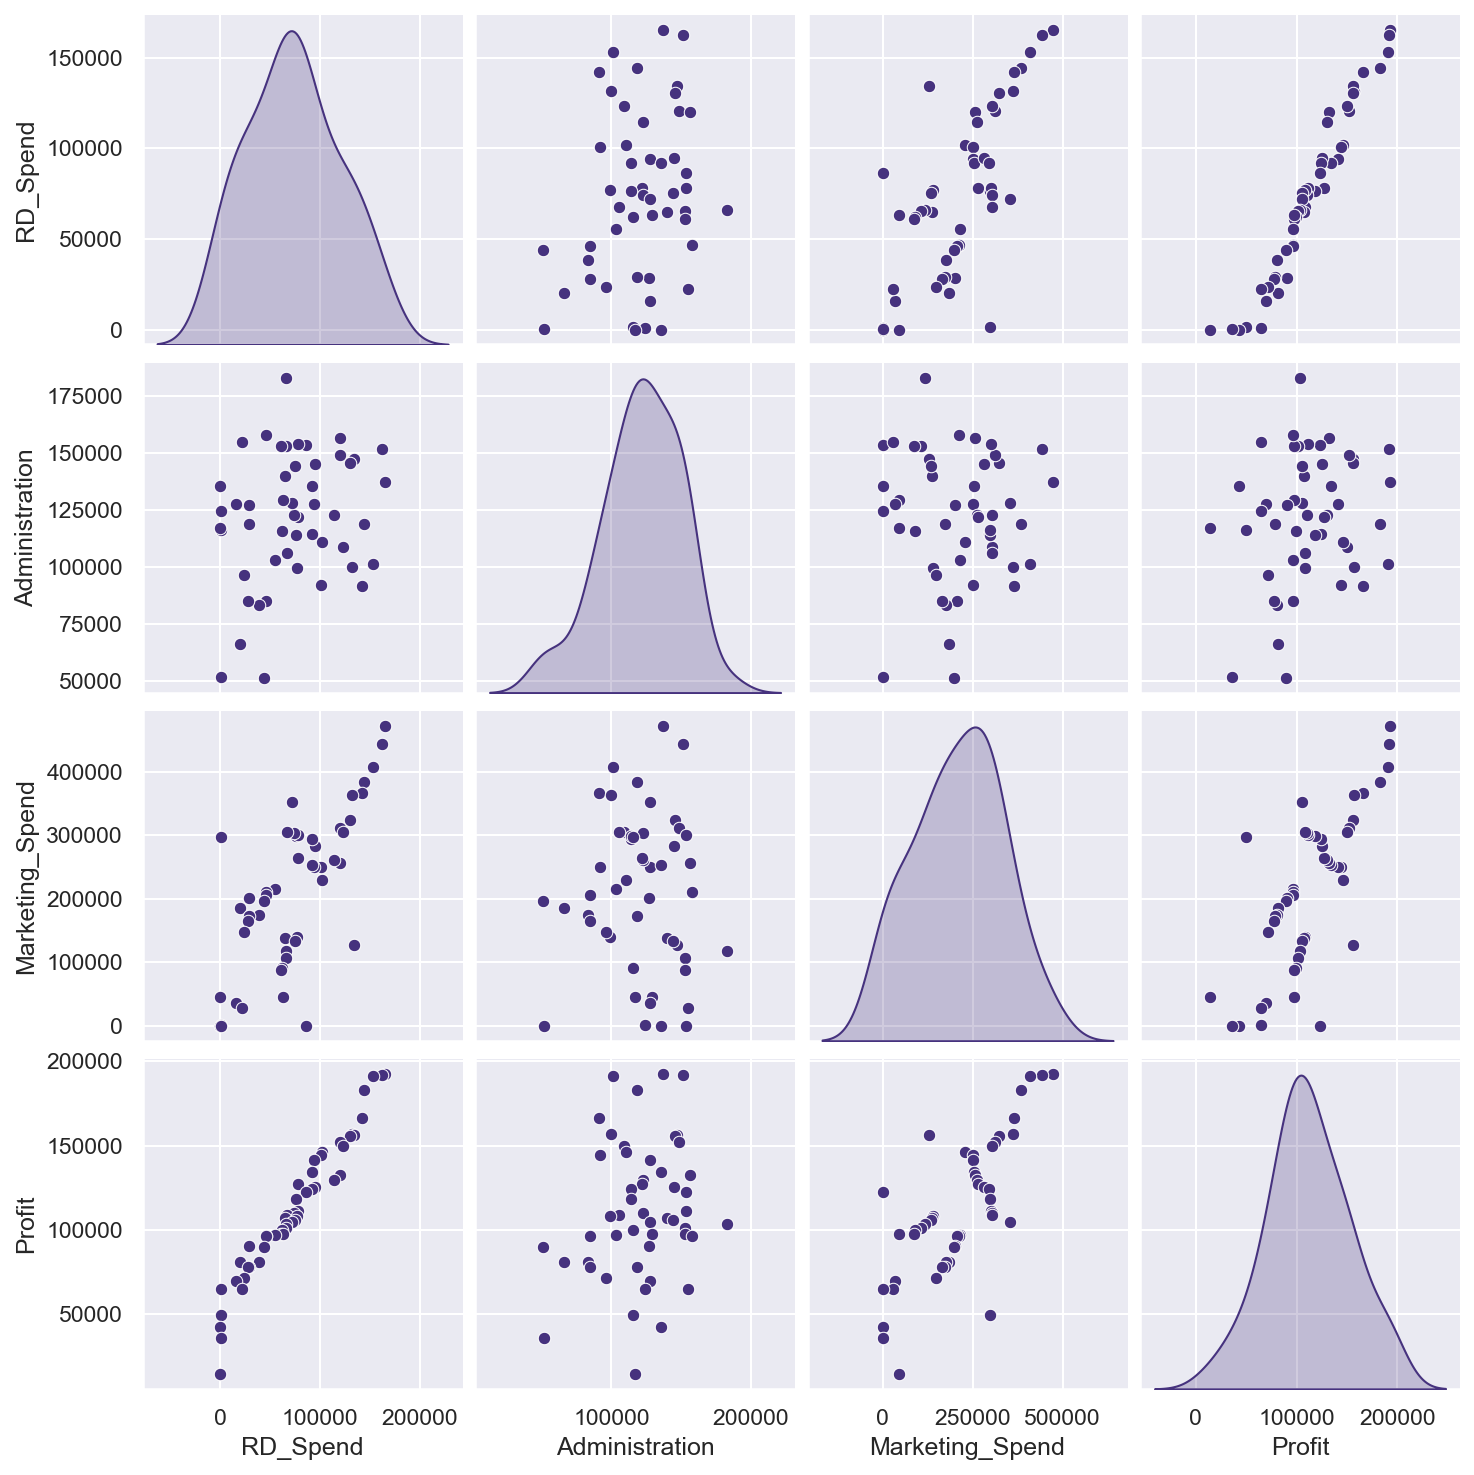

In [8]:
sns.pairplot(data = df, diag_kind='kde')

<Axes: >

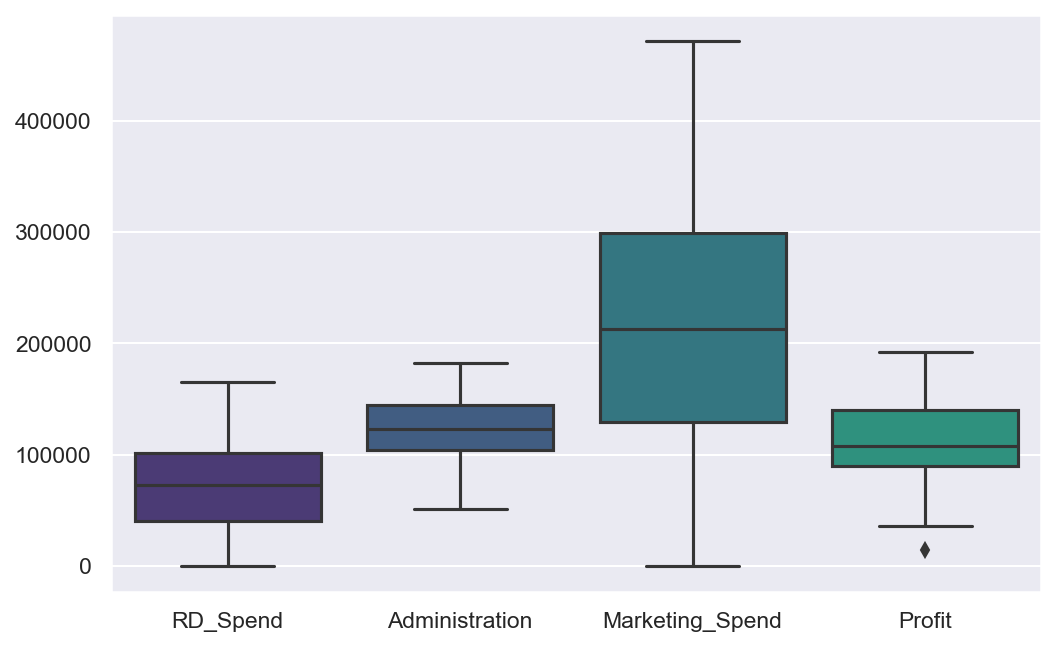

In [8]:
sns.boxplot(df)

<Axes: ylabel='Density'>

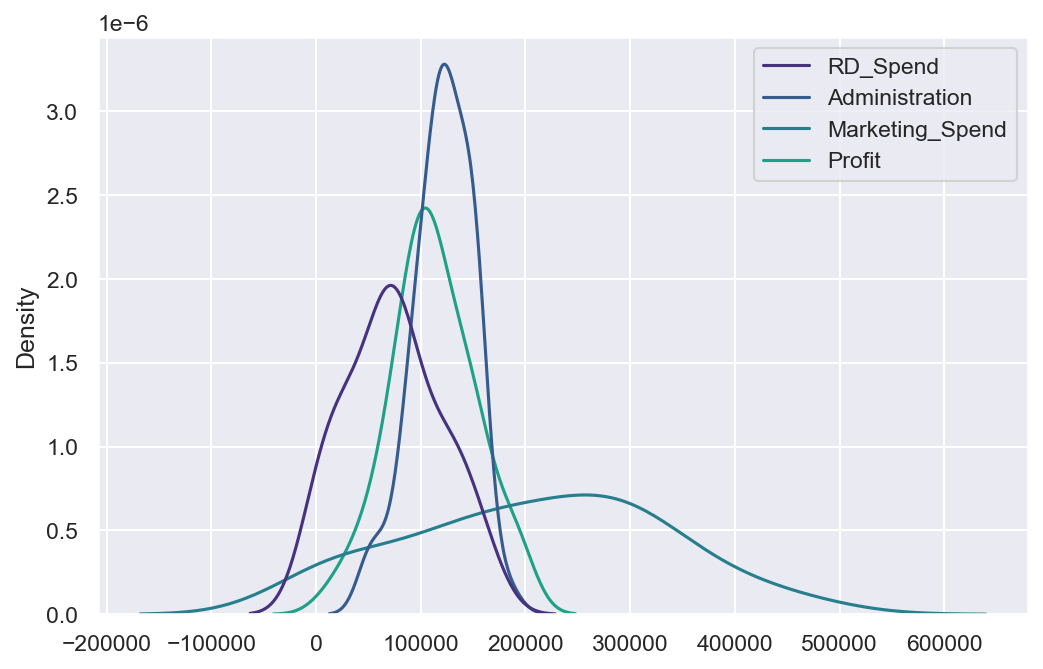

In [41]:
sns.kdeplot(df)

In [42]:
df.skew()

RD_Spend           0.164002
Administration    -0.489025
Marketing_Spend   -0.046472
Profit             0.023291
dtype: float64

In [9]:
# correlation analysis
df.corr()

,RD_Spend,Administration,Marketing_Spend,Profit
RD_Spend,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing_Spend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


<Axes: >

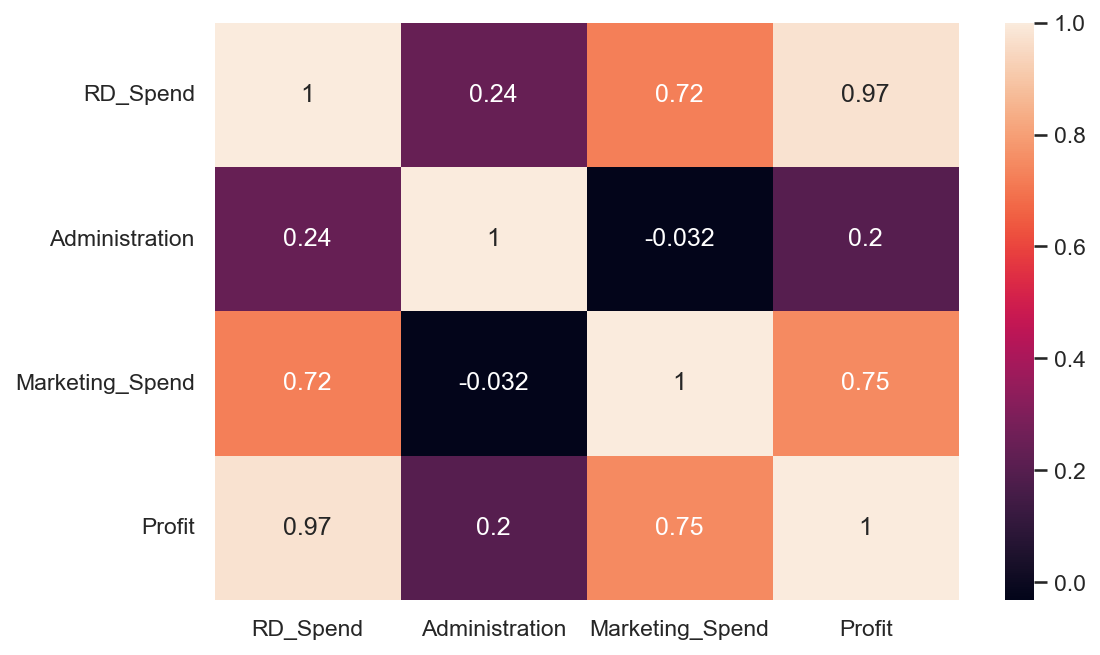

In [10]:
sns.heatmap(df.corr(),annot=True)

## Interpretation
- there is a presence of multicolinearity (there is a moderate correlation btween reseach & development spend and marketing spend)
- we use variance inflation factor to detect the severity of multicolinearit

In [11]:
# checking p values for all features by fitting model 
model = smf.ols('Profit~RD_Spend+Administration+Marketing_Spend',data = df).fit()
model.pvalues

Intercept          1.057379e-09
RD_Spend           2.634968e-22
Administration     6.017551e-01
Marketing_Spend    1.047168e-01
dtype: float64

In [12]:
# checking the effect of R&d on model and comapring checking its p values
model_rd = smf.ols('Profit~RD_Spend+Administration',data = df).fit()
model_rd.pvalues

Intercept         5.695336e-12
RD_Spend          2.278348e-31
Administration    2.888932e-01
dtype: float64

In [13]:
# checking the effect of administration on model and comapring checking its p values
model_ms = smf.ols('Profit~Administration+Marketing_Spend',data = df).fit()
model_ms.pvalues

Intercept          2.589341e-01
Administration     1.729198e-02
Marketing_Spend    9.727245e-11
dtype: float64

In [14]:
# importing vif model form statmodel
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
# as we only want to wrok with feature data we drop the target data 
data =  df.drop('Profit',axis = 1)

In [16]:
# creating the dataframe to store VIF score for various feature variable
vif = pd.DataFrame()
vif['features'] = data.columns

In [17]:
# finding VIF score using list comprehension & storing it into dataframe
vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]

In [18]:
vif

,features,VIF
0,RD_Spend,8.384571
1,Administration,4.026406
2,Marketing_Spend,7.593984


- as the VIF score of R&D spend and marketing spend are close enough we can confirm the check for multicolinearty and best perfoming feature out of these 

In [19]:
df.head()

,RD_Spend,Administration,Marketing_Spend,Profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


- **below perfrom subset selection, we train the model by taking one out of two correlated variable to check the effect o that variable on trainig of model and comapre their R squared and aic value**

In [20]:
# training the model using R&D spend feature with rest other feature
model_rd = smf.ols('Profit~RD_Spend+Administration',data = df).fit()
model_rd.rsquared, model_rd.aic

(0.9478129385009173, 1059.6636934567293)

In [21]:
# training the model using marketing spend with rest other feature
model_ms = smf.ols('Profit~Administration+Marketing_Spend',data = df).fit()
model_ms.rsquared, model_ms.aic

(0.6097229746770663, 1160.2648038638672)

- **from the above comparison we can confirm by comparing R squared and aic score that out of two correlated features R&D spend perfroms better, hence we eleminate Marketing spend feature for our final model**

In [22]:
 scaled_df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)

<Axes: ylabel='Density'>

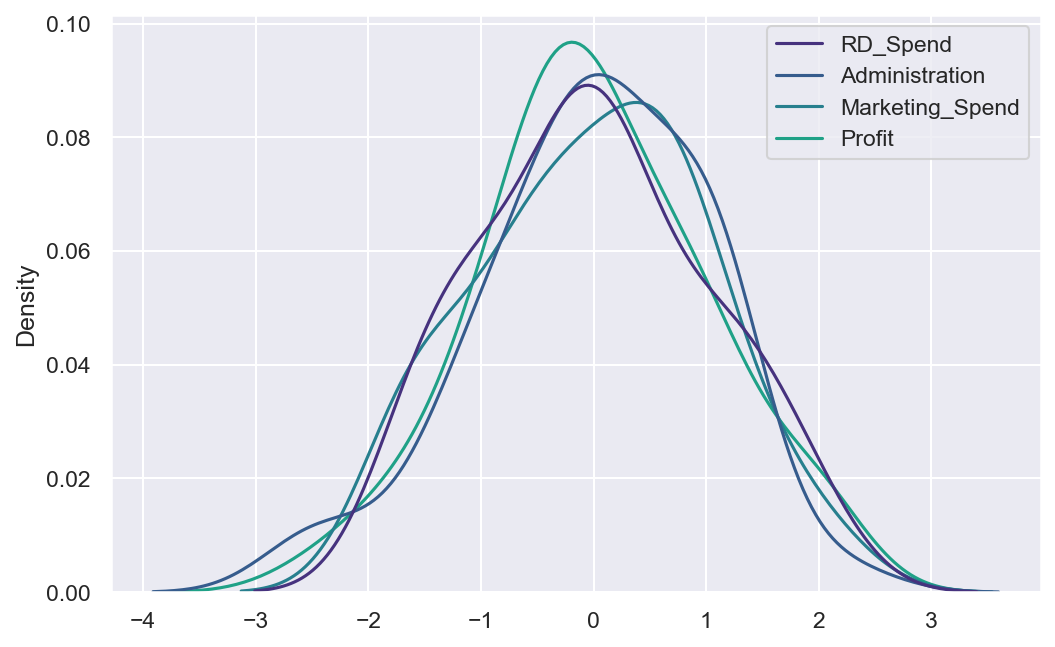

In [23]:
sns.kdeplot(scaled_df)

In [24]:
final_model = smf.ols('Profit~RD_Spend+Administration',data = scaled_df).fit()

In [25]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     426.8
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           7.29e-31
Time:                        20:54:12   Log-Likelihood:                 2.8761
No. Observations:                  50   AIC:                            0.2478
Df Residuals:                      47   BIC:                             5.984
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5.204e-16      0.033  -1.56e-14      1.000      -0.067       0.067
RD_Spend           0.9818      0.034     28.589      0.000       0.913       1.051
Administration    -0.0368      0.034     -1.073      0.289      -0.106       0.032
==============================================================================
Omnibus:                       14.678   Durbin-Watson:                   1.189
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.449
Skew:                          -0.961   Prob(JB):                     3.63e-05
Kurtosis:                       5.474   Cond. No.                         1.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
final_model.pvalues

Intercept         1.000000e+00
RD_Spend          2.278348e-31
Administration    2.888932e-01
dtype: float64

### model validation, residual analysis, model deletion diagnostic

In [27]:
final_model.rsquared

0.9478129385009173

In [28]:
df.head()

,RD_Spend,Administration,Marketing_Spend,Profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


In [29]:
final_model.resid

0     0.052120
1     0.119028
2     0.231556
3     0.246569
4    -0.159610
5    -0.157871
6    -0.175876
7    -0.094081
8     0.032197
9    -0.142763
10    0.231453
11    0.186615
12    0.313893
13    0.182778
14   -0.435900
15   -0.431174
16    0.283048
17   -0.086049
18   -0.091915
19    0.038140
20    0.097291
21   -0.075318
22   -0.045600
23    0.030843
24   -0.187818
25    0.104378
26   -0.161823
27   -0.132010
28    0.028344
29   -0.058436
30   -0.056819
31   -0.050558
32   -0.132243
33   -0.012242
34    0.254592
35    0.161161
36    0.447192
37   -0.005343
38    0.310695
39   -0.068298
40    0.121452
41    0.084071
42    0.033288
43    0.206893
44   -0.015090
45    0.394894
46   -0.009830
47   -0.129066
48   -0.424509
49   -0.852248
dtype: float64

Text(0.5, 1.0, 'q-q plot')

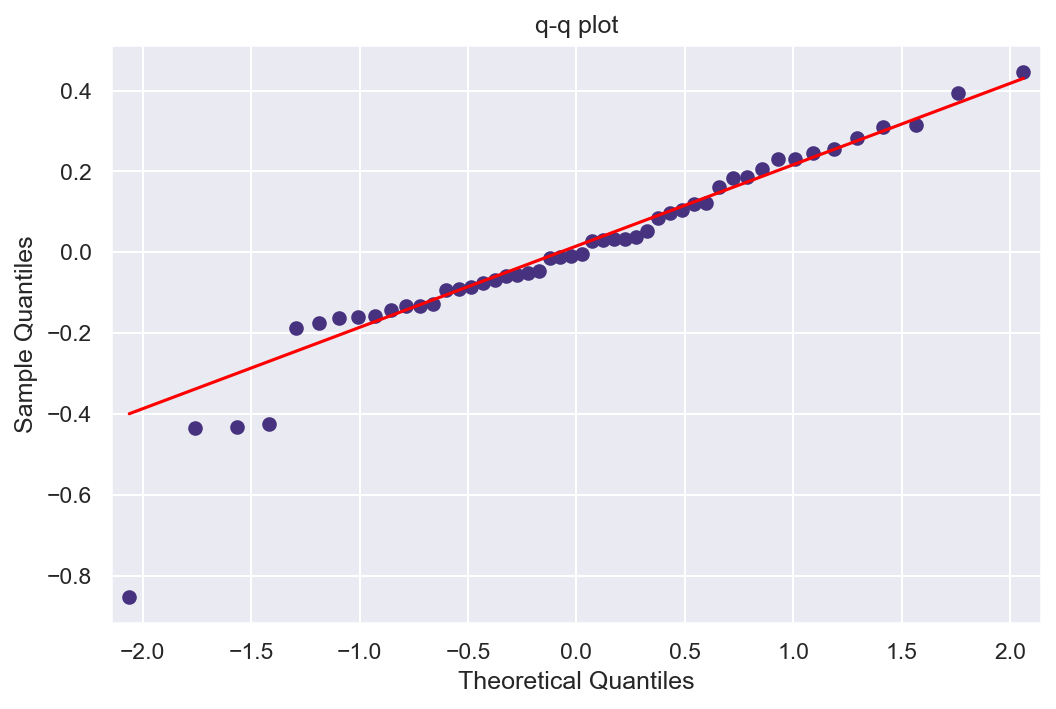

In [30]:
sm.qqplot(final_model.resid, line='q');
plt.title('q-q plot')

In [31]:
np.argmin(final_model.resid), np.min(final_model.resid)

(49, -0.8522478895733072)

Text(0.5, 1.0, 'resudial scatter plot')

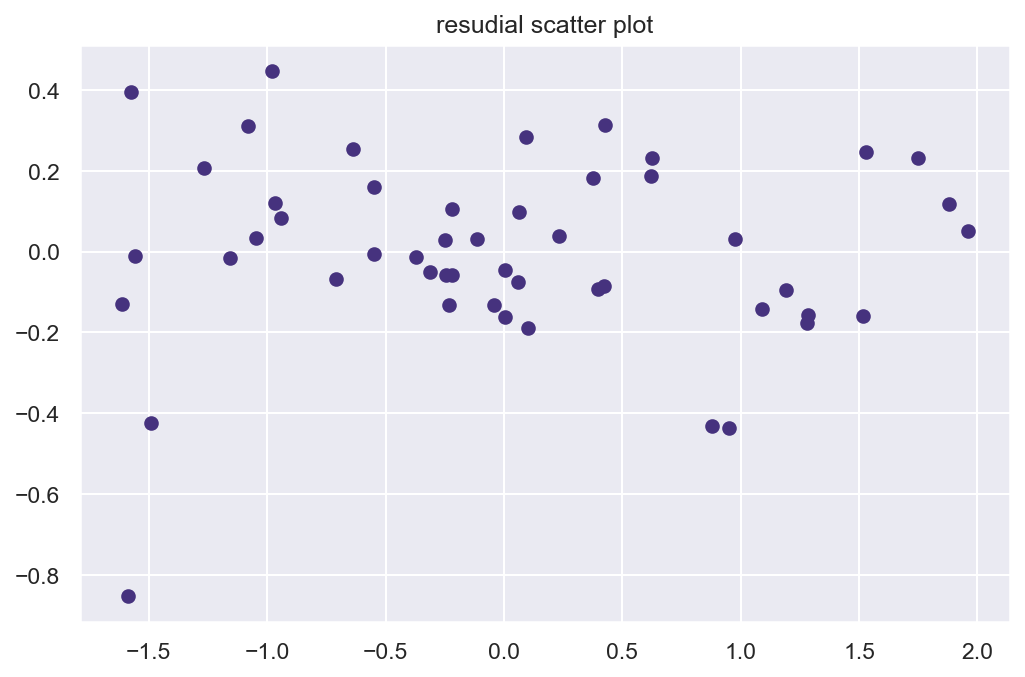

In [32]:
plt.scatter(final_model.fittedvalues, final_model.resid)
plt.title('resudial scatter plot')

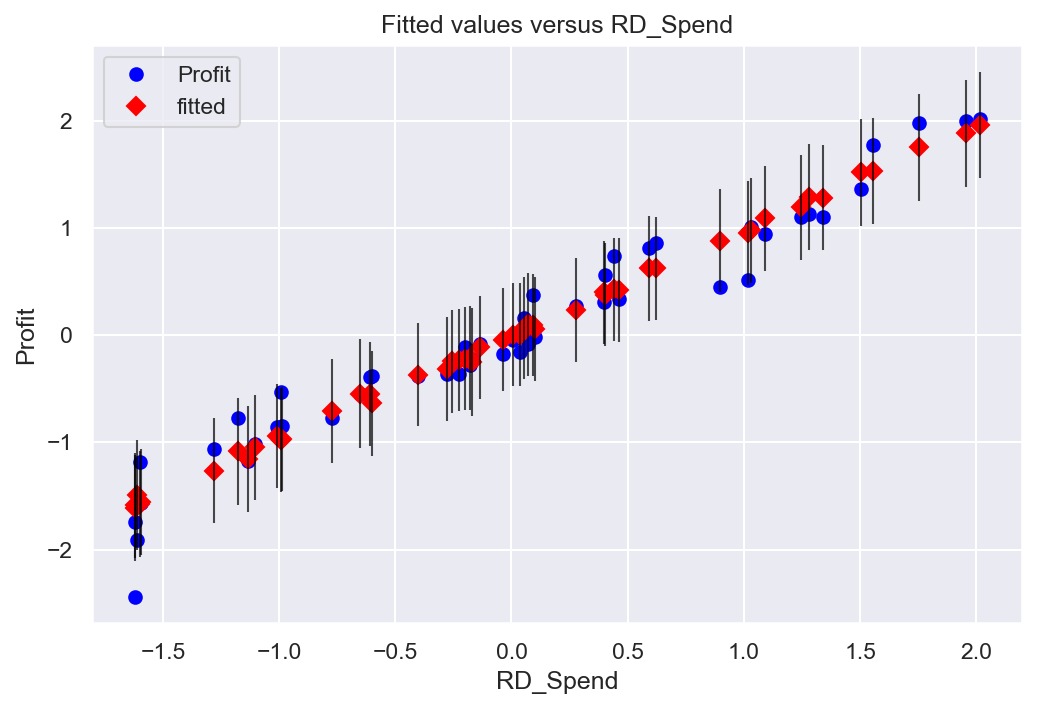

In [33]:
sm.graphics.plot_fit(final_model,'RD_Spend');

In [34]:
#Find the influence data
inf = final_model.get_influence()

#Calculate the cooks distance
c , p = inf.cooks_distance

In [35]:
c

array([2.04891117e-03, 1.10719705e-02, 4.45970340e-02, 3.10535270e-02,
       2.11438476e-02, 1.36907373e-02, 1.35107805e-02, 3.46841651e-03,
       3.66234828e-04, 7.51800918e-03, 1.16600707e-02, 1.36901599e-02,
       1.50207539e-02, 5.68804702e-03, 8.17568588e-02, 4.42094438e-02,
       1.01122046e-02, 1.72273244e-03, 1.37988343e-03, 4.50957682e-04,
       1.29256181e-03, 1.80511998e-03, 2.60725721e-04, 1.58579967e-04,
       7.75429813e-03, 2.18516446e-03, 5.74156819e-03, 2.32513846e-03,
       8.13668428e-04, 1.14848791e-03, 4.40912370e-04, 8.88021449e-04,
       2.58413417e-03, 2.86214125e-05, 3.26636622e-02, 9.81464013e-03,
       5.76430905e-02, 3.48387257e-05, 8.04974487e-02, 1.98645424e-03,
       3.84314890e-03, 3.15370564e-03, 3.93186682e-04, 1.70395623e-02,
       1.53194084e-04, 8.37159585e-02, 4.81274516e-05, 1.08495170e-02,
       2.61113283e-01, 3.75268147e-01])

Text(0.5, 1.0, 'cooks distance plot')

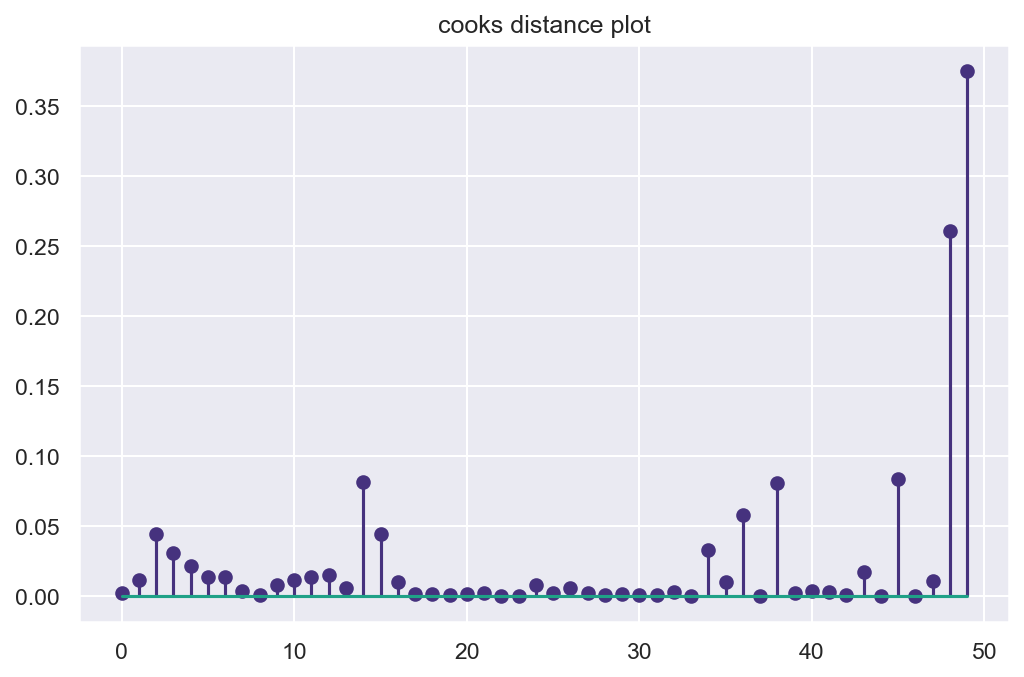

In [36]:
plt.stem(c)
plt.title('cooks distance plot')

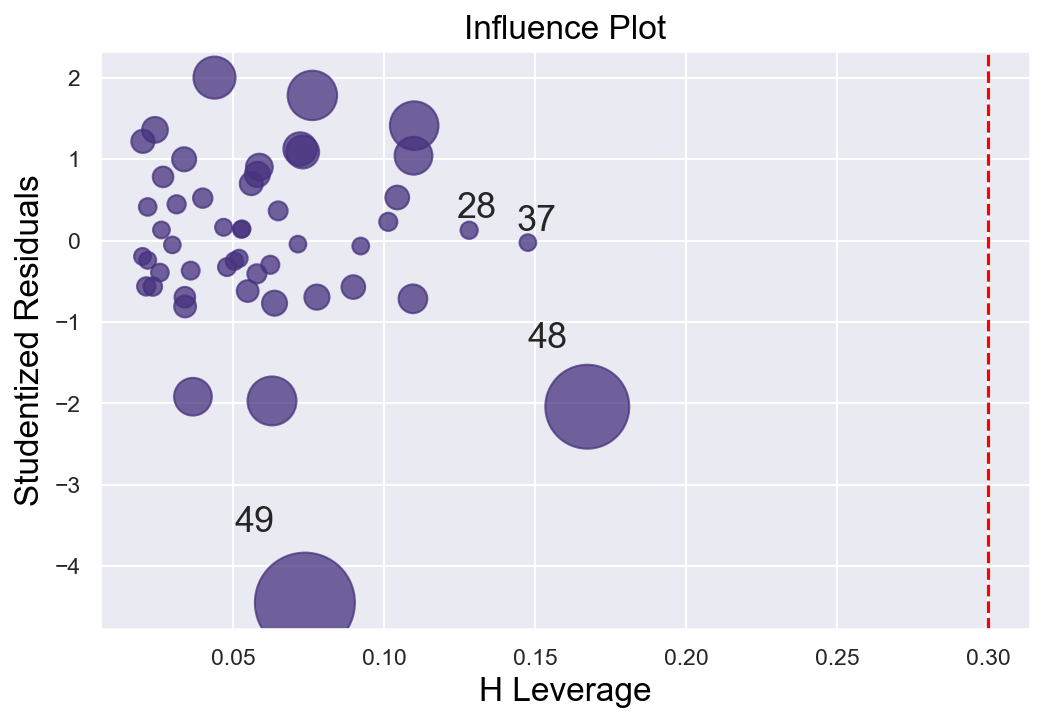

In [37]:
k = len(df.columns)
n = len(df)

lv = 3*(k+1)/n
lv

influence_plot(final_model)
plt.axvline(lv, linestyle = '--', color = 'red')

### Final interpretation
- all the assumptions of multiple linear regression are satisfied 
- model with R&D_spend and Adiministration feature is best performing feature
- there is no outler, influencetial data or leveraging  data ponts
- from model validation we can confirm that the model is perfroming well
- from model deletion diagnostic we can confirm that there is no outlier to delete or deal with and the perfromace of model is nominal